# Natural Language Processing with Disaster Tweets

Importing all packages

In [705]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from sklearn import feature_extraction, linear_model, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Reading data from files (test and train)

In [706]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

Example data

In [707]:
df_train



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [708]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Number of all records

In [709]:
df_train['id'].count()

7613

Count and graph of non-disaster/disaster tweets

In [710]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

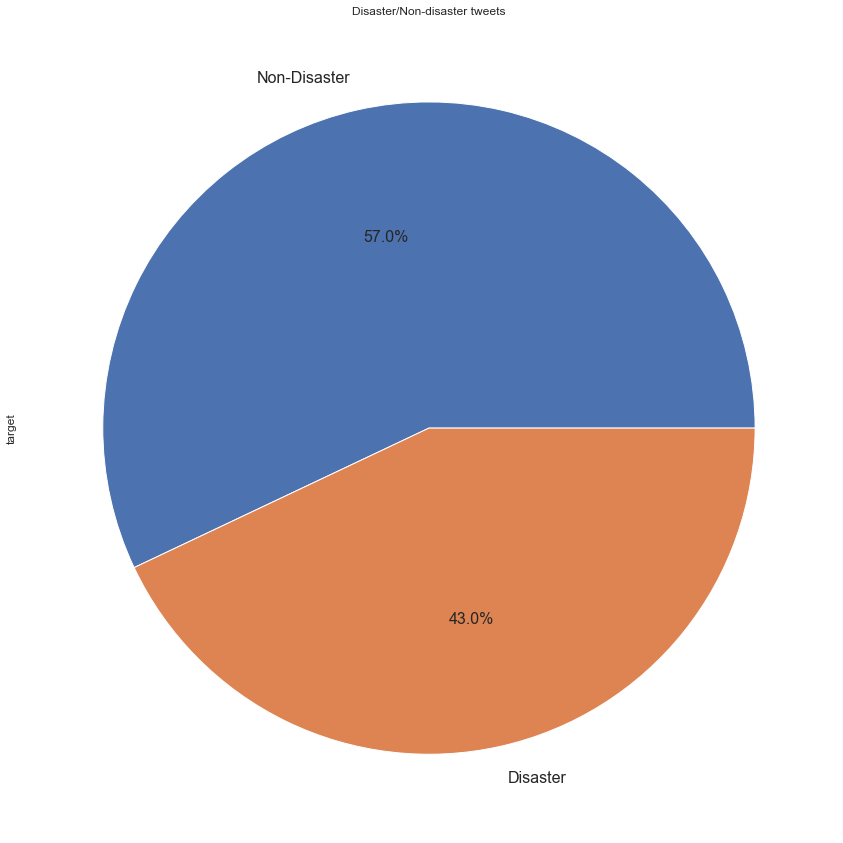

In [711]:
df_train['target'].value_counts().plot(kind='pie',
                                         title='Disaster/Non-disaster tweets', 
                                         autopct='%1.1f%%',
                                         shadow=False,
                                         labels=['Non-Disaster', 'Disaster'],
                                         legend = False, fontsize=16, figsize=(15,15))
plt.show()

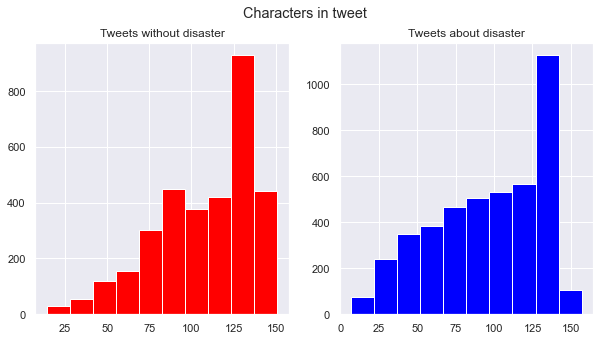

In [712]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize = (10,5))
disaster_tweets_len = df_train[df_train['target']==1]['text'].str.len()
ax1.hist(disaster_tweets_len, color = 'red')
ax1.set_title('Tweets without disaster')

notdisaster_tweets_len = df_train[df_train['target']==0]['text'].str.len()
ax2.hist(notdisaster_tweets_len, color = 'blue')
ax2.set_title('Tweets about disaster')

fig.suptitle('Characters in tweet')
plt.show()

List of the most occurring words in keyboard (general)

In [713]:
df_train.keyword.value_counts().sort_values(ascending=False)

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

List of the most occurring words in keyboard (only in disaster tweets)

In [714]:
df_train_true_key = df_train[df_train['target'] == 1].keyword.value_counts().sort_values(ascending=False)
df_train_true_key

derailment     39
outbreak       39
wreckage       39
debris         37
typhoon        37
               ..
blazing         1
epicentre       1
body%20bag      1
electrocute     1
ruin            1
Name: keyword, Length: 220, dtype: int64

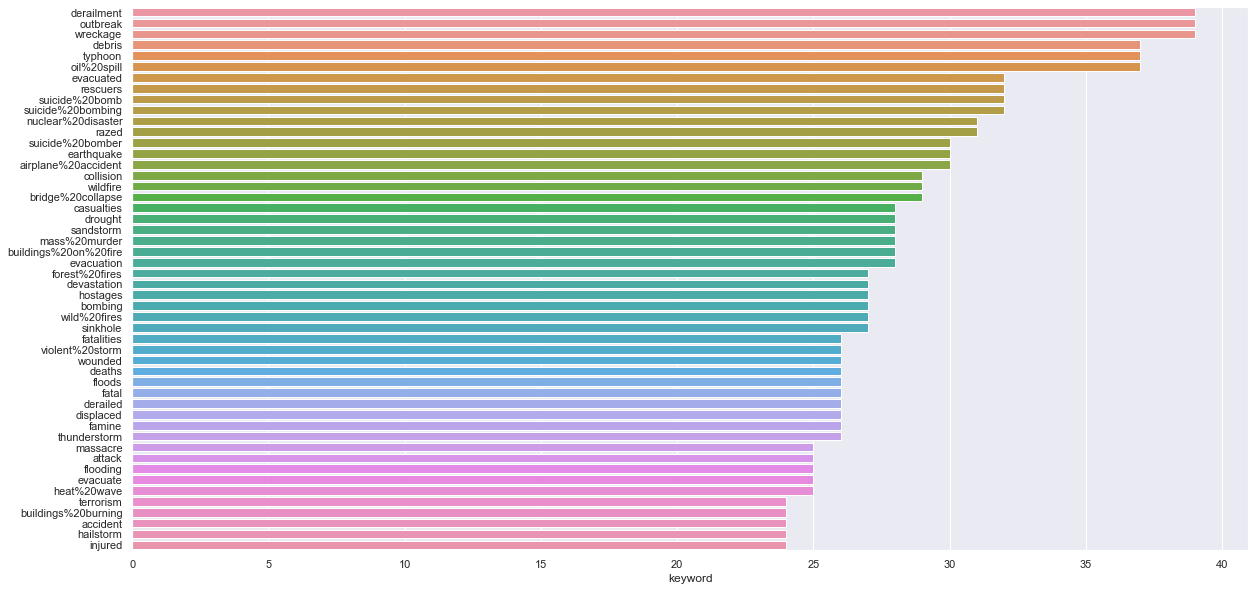

In [715]:
sns.barplot(y = df_train_true_key.index[:50], x = df_train_true_key[:50])
sns.set(rc={'figure.figsize':(20, 10)})

# Cleaning data



Change all text to lower case

In [716]:
df_train['text'].head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [717]:

def lowerText(text):
    text = text.lower()
    return text

df_train['text'] = df_train['text'].apply(lambda x : lowerText(x))

df_train['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

Remove ASCII spaces and ampersands

In [718]:
def removeAscii(text):
    rem = re.compile(r'%20')
    return rem.sub(r'', text)

def changeAnd(text):
    ch = re.compile(r'&amp;')
    return ch.sub(r'and', text)

df_train['text'] = df_train['text'].apply(lambda x : removeAscii(x))
df_train['text'] = df_train['text'].apply(lambda x : changeAnd(x))

Remove links

In [719]:
ex = df_train.iloc[40,3]
ex

'check these out: http://t.co/roi2nsmejj http://t.co/3tj8zjin21 http://t.co/yduixefipe http://t.co/lxtjc87kls #nsfw'

In [720]:
def deleteLinks(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [721]:
df_train['text'] = df_train['text'].apply(lambda sentence: deleteLinks(sentence))

In [722]:
ex = df_train.iloc[40,3]
ex

'check these out:     #nsfw'

Change acronyms to normal words

In [723]:
ex2 = df_train.iloc[280,3]
ex2

"but if it's the apocalypse lol gf m8"

In [724]:
acronyms = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}
def removeAcronyms(text):
    newtext = ""
    for word in text.split():
        w = acronyms[word.lower()] if word.lower() in acronyms.keys() else word
        newtext += w + " "
    return newtext

df_train['text'] = df_train['text'].apply(lambda x : removeAcronyms(x))

In [725]:
ex2 = df_train.iloc[280,3]
ex2

"but if it's the apocalypse laughing out loud gf mate "

Delete all stop words

In [726]:
stopWords = nltk.corpus.stopwords.words('english')
df_train.iloc[2000,3]

'@bradleybrad47 the saw is fast af and does great damage i upgraded it a shitton and used it exclusively for a whole playthrough '

In [727]:
def removeStopWords(text):
    return ' '.join([word for word in text.split() if word not in (stopWords)])
    
df_train['text'] = df_train['text'].apply(lambda x : removeStopWords(x))
df_train.iloc[2000,3]

'@bradleybrad47 saw fast af great damage upgraded shitton used exclusively whole playthrough'

In [728]:
def cleanData(text):
    text = lowerText(text)
    text = removeAscii(text)
    text = changeAnd(text)
    text = deleteLinks(text)
    text = removeAcronyms(text)
    text = removeStopWords(text)

df_test['text'] = df_test['text'].apply(lambda x : cleanData(x))

# Tokenization

In [729]:
#tokenizator = nltk.tokenize.RegexpTokenizer(r'\w+')
#df_train['text'] = df_train['text'].apply(lambda x:tokenizator.tokenize(x))
#df_train.head()

#tokenizer = nltk.tokenize.TreebankWordTokenizer()
#tokens = tokenizer.tokenize(df_train['text'])

# Stemmer
#stemmer = nltk.stem.PorterStemmer()
#print("Stemming the sentence: ", " ".join(stemmer.stem(token) for token in tokens))

# Lemmatizer
#lemmatizer=nltk.stem.WordNetLemmatizer()
#print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

# Vectorization

In [730]:
count_vectorization = feature_extraction.text.CountVectorizer()
train_vector = count_vectorization.fit_transform(df_train['text'])

# Model

Ridge regression classifier

In [731]:
mod = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(mod,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.59597806, 0.44677138, 0.53846154, 0.47744361, 0.65030675])

In [732]:
mod.fit(train_vector,df_train["target"])

RidgeClassifier()

Logistic regression classifier

In [733]:
mod2 = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(mod2,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.60496183, 0.51034483, 0.57023411, 0.52207294, 0.70718232])

In [734]:
mod2.fit(train_vector,df_train["target"])

LogisticRegression()

Naive Bayes Classifier

In [735]:
mod3 = MultinomialNB()
scores = model_selection.cross_val_score(mod3,train_vector,df_train['target'],cv = 5,scoring="f1")
scores

array([0.63568465, 0.61849711, 0.68678161, 0.64263323, 0.72423025])

In [736]:
mod3.fit(train_vector,df_train["target"])

MultinomialNB()